## Phase 5: Model Development

### Setup Phase

In [1]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [2]:
# Load the processed dataset
data_path = "BikeML/data/refined_combined_data_with_features.csv"
combined_data = pd.read_csv(data_path)

In [3]:
# Preview the data
print(combined_data.head())

                start_date                 end_date  duration_sec  is_member  \
0  2021-06-29 17:46:28.653  2021-06-29 19:33:25.700          6417          0   
1  2021-04-25 18:02:39.110  2021-04-25 18:13:26.139           647          0   
2  2021-08-08 18:50:31.633  2021-08-08 18:58:57.585           505          1   
3  2021-10-11 17:50:15.346  2021-10-11 18:25:31.726          2116          1   
4  2021-09-10 15:51:58.050  2021-09-10 16:21:01.403          1743          1   

         date  max_temp_c  min_temp_c  total_precip_mm  snow_on_grnd_cm  \
0  2021-06-29        28.6        22.3              0.2              0.0   
1  2021-04-25        16.9         1.4              2.4              0.0   
2  2021-08-08        28.4        19.1              0.0              0.0   
3  2021-10-11        21.7        13.8              0.0              0.0   
4  2021-09-10        20.5        14.2              0.4              0.0   

   spd_of_max_gust_kmh  ...  is_weekend  duration_min  temp_range_c 

### Step 1: Define Features and Target

In [4]:
# Define features and target variable
features = [
    'max_temp_c', 'min_temp_c', 'temp_range_c', 'total_precip_mm',
    'snow_on_grnd_cm', 'spd_of_max_gust_kmh', 'is_rainy', 'is_snowy',
    'is_windy', 'start_hour', 'start_weekday', 'is_weekend'
]
target = 'duration_sec'

In [5]:
# Split the data into features (X) and target (y)
X = combined_data[features]
y = combined_data[target]

In [6]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

Training set size: (4309514, 12)
Test set size: (1077379, 12)


### Step 2: Train Models

In [7]:
# Linear Regression
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

LinearRegression()

In [8]:
# Predict on test set
y_pred_linear = linear_model.predict(X_test)

In [9]:
# Decision Tree
tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [10]:
# Predict on test set
y_pred_tree = tree_model.predict(X_test)

In [12]:
# Random Forest
rf_model = RandomForestRegressor(random_state=42, n_estimators=50)

In [13]:
rf_model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=50, random_state=42)

In [14]:
# Predict on test set
y_pred_rf = rf_model.predict(X_test)

### Step 3: Evaluate Models

In [38]:
# Function to evaluate model performance
def evaluate_model(y_test, y_pred, model_name):
    print(f"Performance of {model_name}:")
    print("MAE:", mean_absolute_error(y_test, y_pred))
    print("MSE:", mean_squared_error(y_test, y_pred))
    print("R²:", r2_score(y_test, y_pred))
    print("\n")

In [46]:
# Evaluate all models
evaluate_model(y_test, y_pred_linear, "Linear Regression")
evaluate_model(y_test, y_pred_tree, "Decision Tree")
evaluate_model(y_test, y_pred_rf, "Random Forest")

Performance of Linear Regression:
MAE: 523.8281431901951
MSE: 1197592.557156586
R²: 0.006108867540889906


Performance of Decision Tree:
MAE: 520.7154101992229
MSE: 1209179.4538150006
R²: -0.0035071857425912345


Performance of Random Forest:
MAE: 520.7650996556962
MSE: 1205607.7572928583
R²: -0.0005430077506867192




### Step 4: Hyperparameter Tuning for Random Forest

In [39]:
# Subset the training data (50% of the training set)
X_train_sample = X_train.sample(frac=0.5, random_state=42)
y_train_sample = y_train.loc[X_train_sample.index]

In [40]:
param_dist = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

In [41]:
X_train_sample = X_train.sample(frac=0.25, random_state=42)
y_train_sample = y_train.loc[X_train_sample.index]

In [42]:
# RandomizedSearchCV
rf_random = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=5,  # Fewer combinations
    cv=2,      # Fewer folds
    scoring='neg_mean_squared_error',
    verbose=2,
    random_state=42,
    n_jobs=-1
)

In [43]:
rf_random.fit(X_train_sample, y_train_sample)

Fitting 2 folds for each of 5 candidates, totalling 10 fits


RandomizedSearchCV(cv=2, estimator=RandomForestRegressor(random_state=42),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'max_depth': [10, 20],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [50, 100]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [44]:
print("Best Parameters:", rf_random.best_params_)
best_rf_model = rf_random.best_estimator_

Best Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 10}


In [45]:
y_pred_rf_best = best_rf_model.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred_rf_best))
print("MSE:", mean_squared_error(y_test, y_pred_rf_best))
print("R²:", r2_score(y_test, y_pred_rf_best))

MAE: 522.1571548201831
MSE: 1202913.1014426022
R²: 0.0016933075458590574


### Step 5: Analyze Model Performance

In [47]:
# Define a function to collect and summarize model performance
def summarize_model_performance(model_name, y_test, y_pred):
    return {
        "Model": model_name,
        "MAE": mean_absolute_error(y_test, y_pred),
        "MSE": mean_squared_error(y_test, y_pred),
        "R²": r2_score(y_test, y_pred)
    }

In [48]:
# Collect performance data
performance_data = [
    summarize_model_performance("Linear Regression", y_test, y_pred_linear),
    summarize_model_performance("Decision Tree", y_test, y_pred_tree),
    summarize_model_performance("Random Forest (Default)", y_test, y_pred_rf),
    summarize_model_performance("Tuned Random Forest", y_test, y_pred_rf_best)
]

In [49]:
# Convert to a DataFrame for visualization
import pandas as pd
performance_df = pd.DataFrame(performance_data)

In [50]:
# Display the table
print(performance_df)

                     Model         MAE           MSE        R²
0        Linear Regression  523.828143  1.197593e+06  0.006109
1            Decision Tree  520.715410  1.209179e+06 -0.003507
2  Random Forest (Default)  520.765100  1.205608e+06 -0.000543
3      Tuned Random Forest  522.157155  1.202913e+06  0.001693


### Step 6: Interpret Results

In [51]:
# Plot feature importance for the tuned Random Forest
import matplotlib.pyplot as plt
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

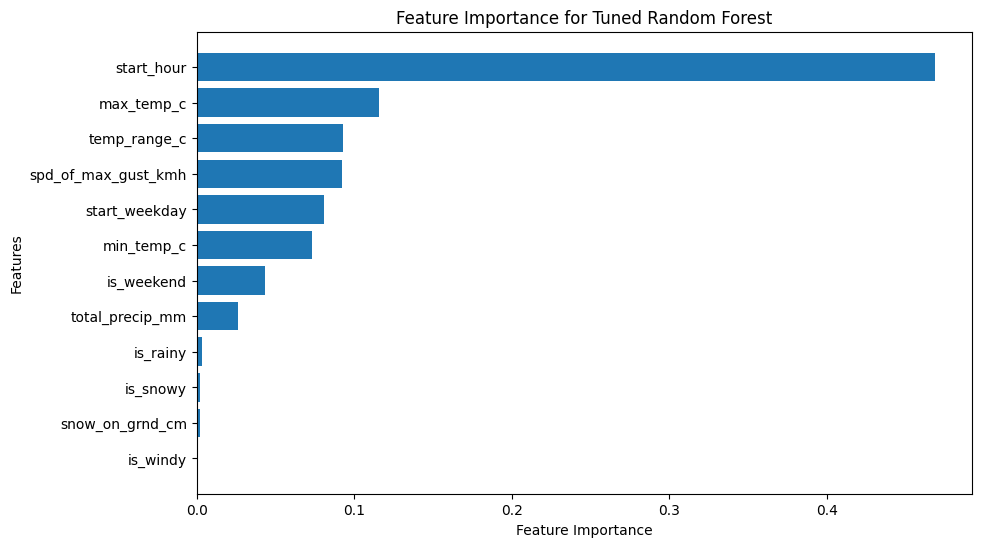

In [52]:
# Plot
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance for Tuned Random Forest")
plt.gca().invert_yaxis()
plt.show()

### Step 7: Save the Best Model

In [63]:
import joblib

In [64]:
# Save the tuned Random Forest model
joblib.dump(best_rf_model, "BikeML/models/tuned_random_forest.pkl")

['BikeML/models/tuned_random_forest.pkl']

In [65]:
print("Model saved successfully!")

Model saved successfully!


### Step 8: Make Predictions Using the Best Model

In [66]:
# Load the saved model
loaded_model = joblib.load("BikeML/models/tuned_random_forest.pkl")

In [67]:
# Example prediction
sample_data = X_test.iloc[:5]  # Use the first 5 rows as an example
predictions = loaded_model.predict(sample_data)

In [68]:
print("Sample Predictions:", predictions)

Sample Predictions: [ 834.05949732 1023.10407446 1053.79049212  797.21566545  673.04138977]


### Step 9: Error Analysis

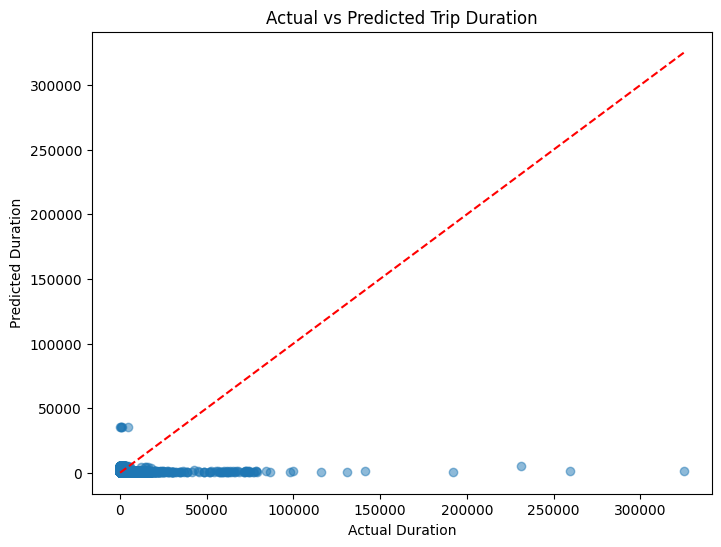

In [69]:
# Scatter plot: Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_rf_best, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Duration")
plt.ylabel("Predicted Duration")
plt.title("Actual vs Predicted Trip Duration")
plt.show()

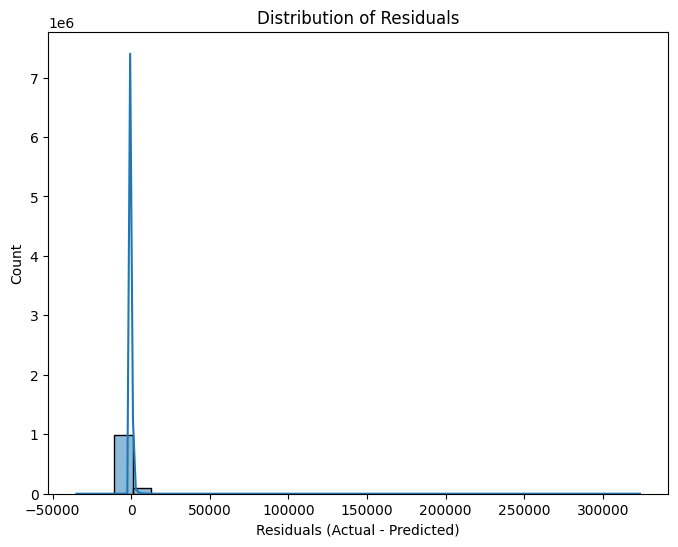

In [70]:
# Distribution of residuals
residuals = y_test - y_pred_rf_best
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.title("Distribution of Residuals")
plt.xlabel("Residuals (Actual - Predicted)")
plt.show()

### Step 10: Analyze Outliers

In [90]:
# Step 1: Create a DataFrame for residuals with the same index as y_test
residuals_df = pd.DataFrame({
    'residuals': residuals
}, index=y_test.index)

In [91]:
# Step 2: Merge residuals with the test portion of combined_data
combined_test_data = combined_data.loc[y_test.index].copy()  # Extract test rows from the original dataset
combined_test_data['residuals'] = residuals_df['residuals']  # Add residuals to the DataFrame

In [92]:
# Step 3: Define a threshold and identify outliers
outlier_threshold = 100000  # Threshold for high residuals
outliers = combined_test_data[np.abs(combined_test_data['residuals']) > outlier_threshold]

In [93]:
# Step 4: Print summary of outliers
print("Number of Outliers:", outliers.shape[0])
print("Outliers:\n", outliers)

Number of Outliers: 7
Outliers:
                       start_date                 end_date  duration_sec  \
1382221  2021-04-10 19:37:25.613  2021-04-12 10:51:21.982        141236   
2667378  2021-04-09 14:47:42.973  2021-04-12 14:50:38.451        259375   
4468820  2021-06-15 13:59:00.552  2021-06-16 22:11:40.638        115960   
5182252  2021-06-14 22:08:57.415  2021-06-16 10:31:05.773        130928   
667465   2021-04-14 18:01:20.776  2021-04-17 10:19:00.671        231459   
3010197  2021-04-18 14:22:17.180  2021-04-22 08:38:33.925        324976   
2451559  2021-04-22 08:53:10.744  2021-04-24 14:11:58.563        191927   

         is_member        date  max_temp_c  min_temp_c  total_precip_mm  \
1382221          0  2021-04-10        23.0         8.8              0.0   
2667378          1  2021-04-09        24.6         7.1              0.0   
4468820          1  2021-06-15        23.8        13.0              0.2   
5182252          0  2021-06-14        23.6        17.5            

In [94]:
# Optional: Explore the outlier features visually
import seaborn as sns
import matplotlib.pyplot as plt

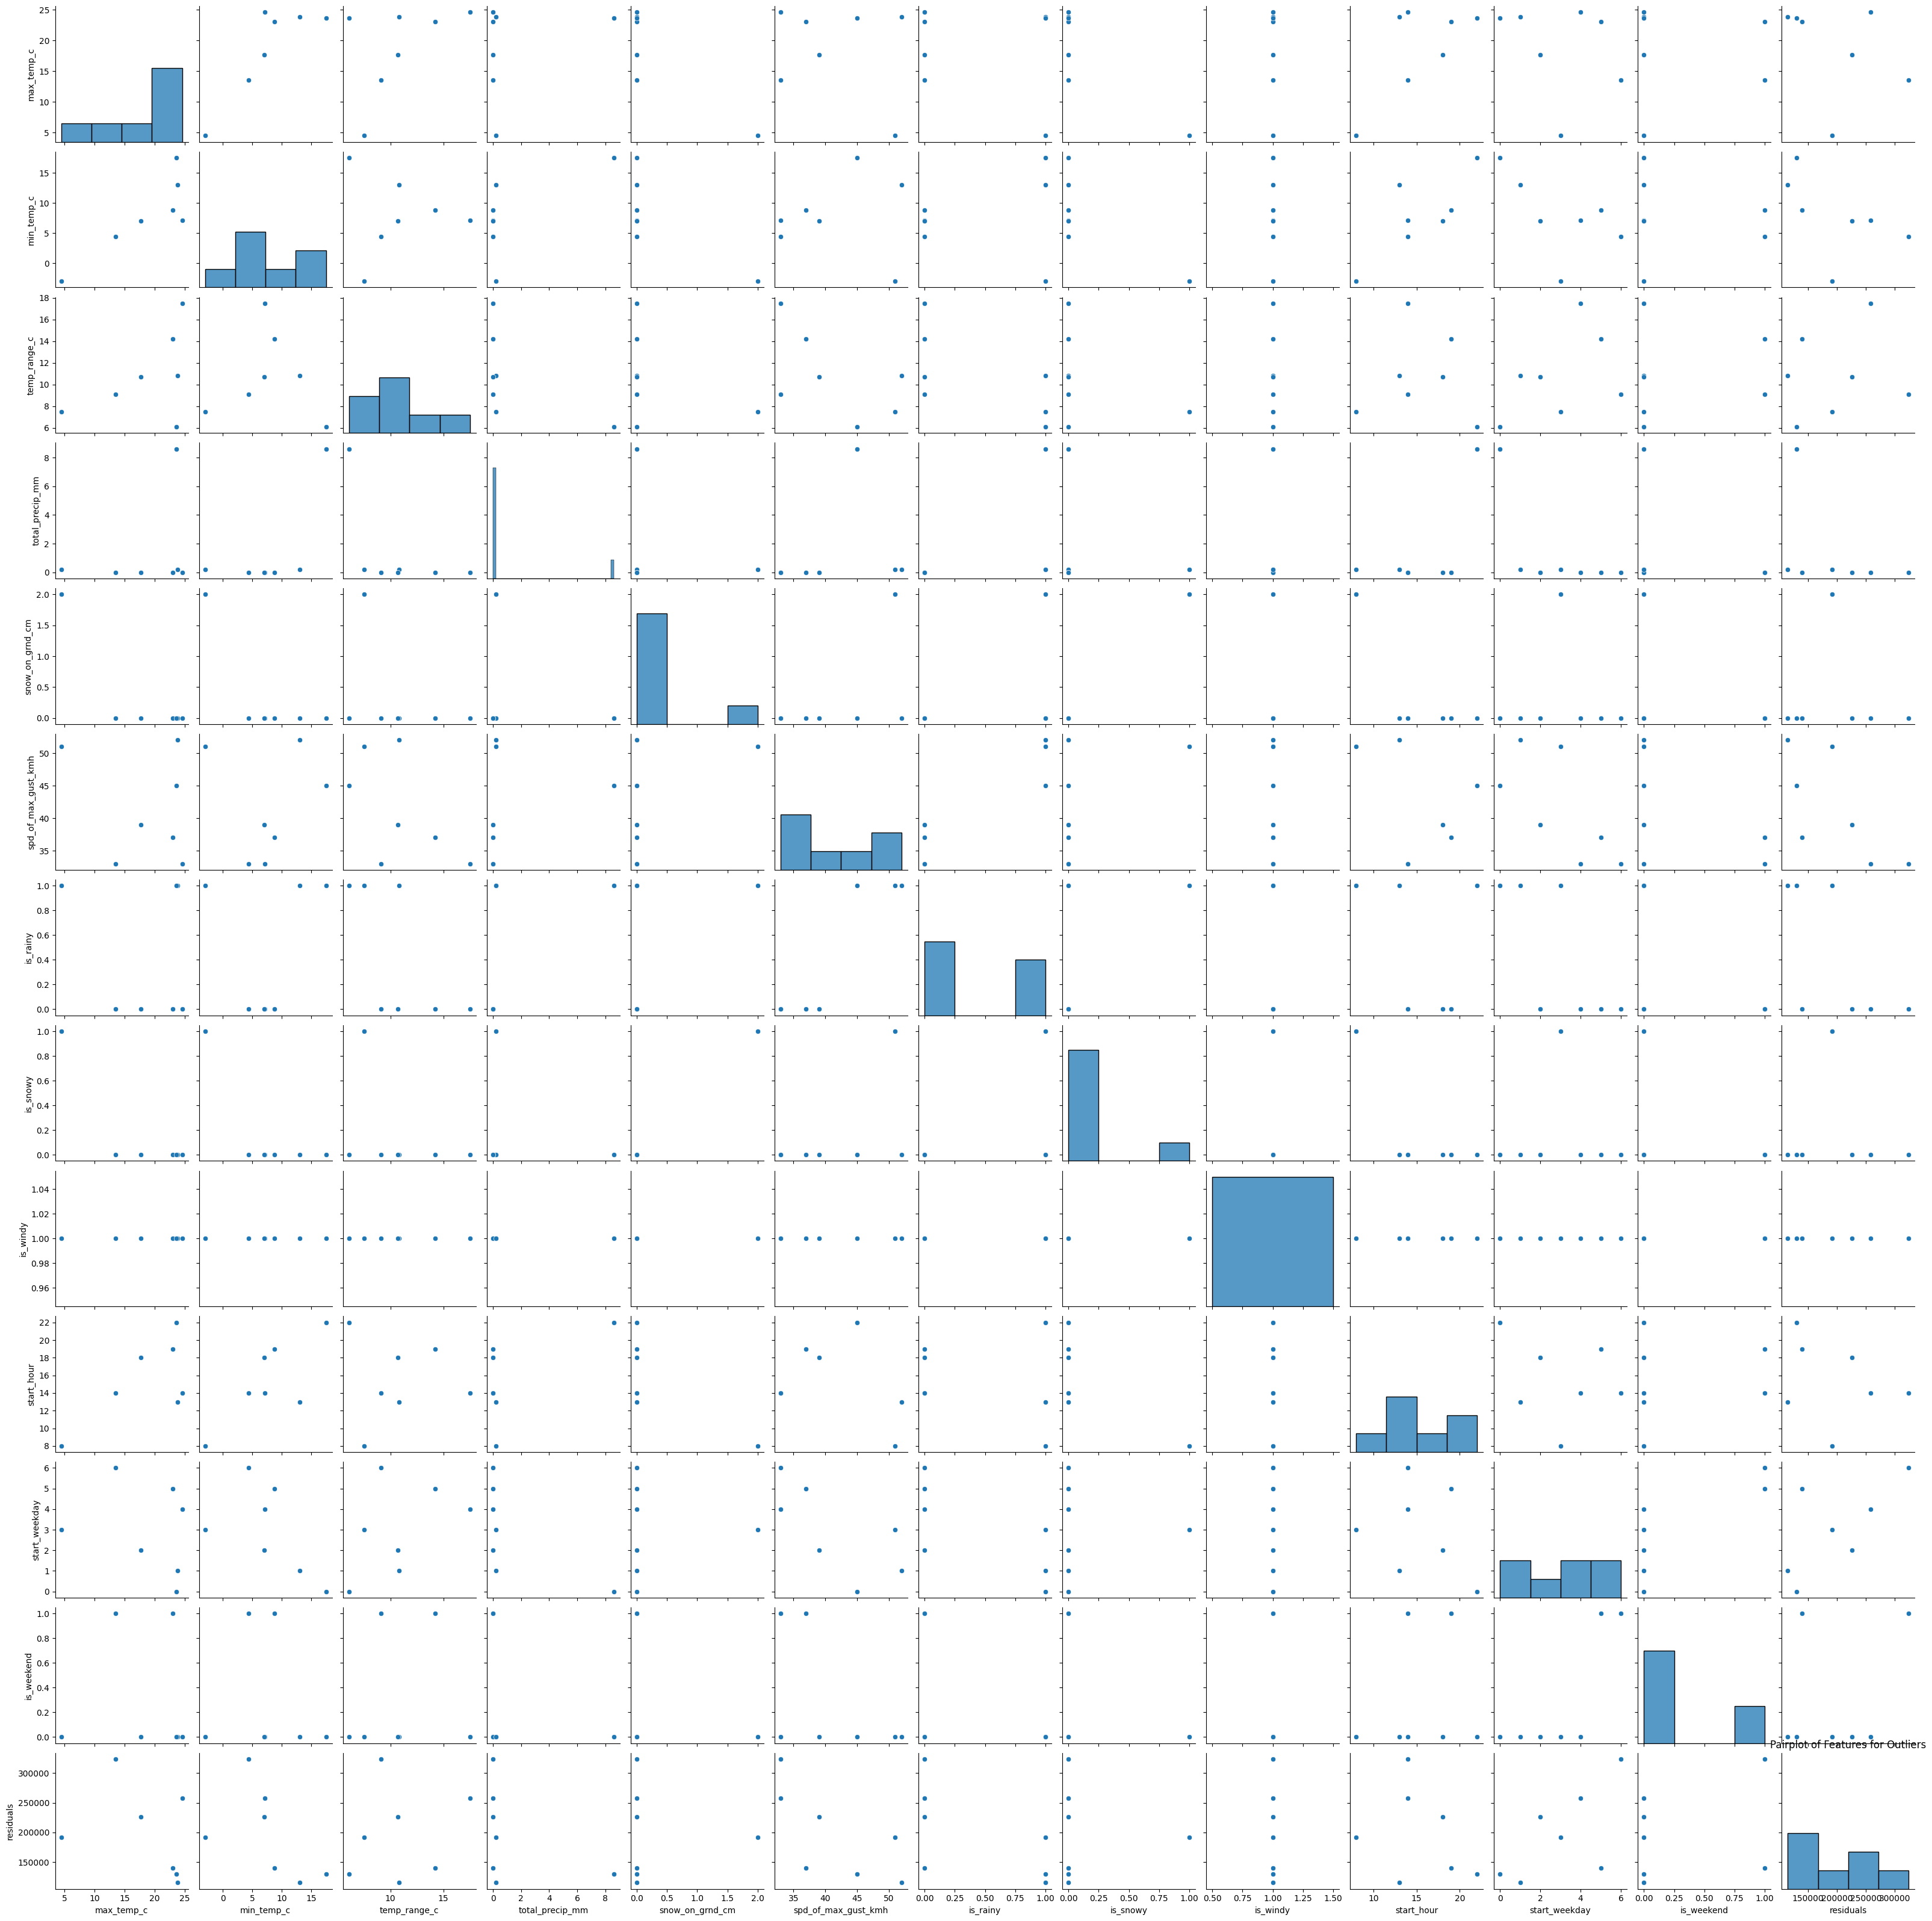

In [95]:
# Pairplot for outliers
sns.pairplot(outliers[features + ['residuals']])
plt.title("Pairplot of Features for Outliers")
plt.show()

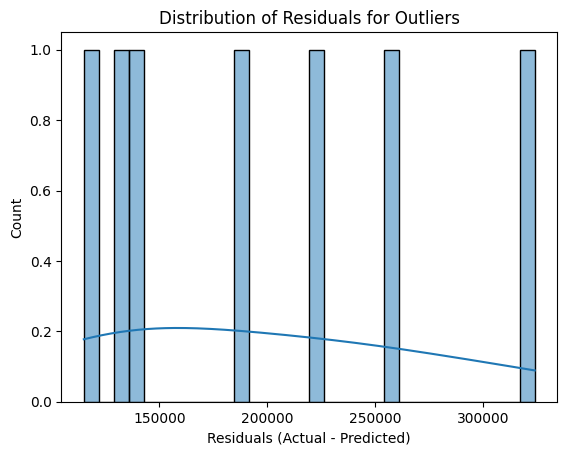

In [96]:
# Distribution of residuals for outliers
sns.histplot(outliers['residuals'], kde=True, bins=30)
plt.title("Distribution of Residuals for Outliers")
plt.xlabel("Residuals (Actual - Predicted)")
plt.show()

In [98]:
# Remove outliers from the test set
combined_test_data_cleaned = combined_test_data[~(np.abs(combined_test_data['residuals']) > outlier_threshold)]

### Verifying the Impact

In [99]:
# Remove outliers
cleaned_test_data = combined_test_data[~(np.abs(combined_test_data['residuals']) > outlier_threshold)]

In [100]:
# Recalculate predictions for cleaned data
y_cleaned_actual = cleaned_test_data['duration_sec']
y_cleaned_predicted = best_rf_model.predict(cleaned_test_data[features])

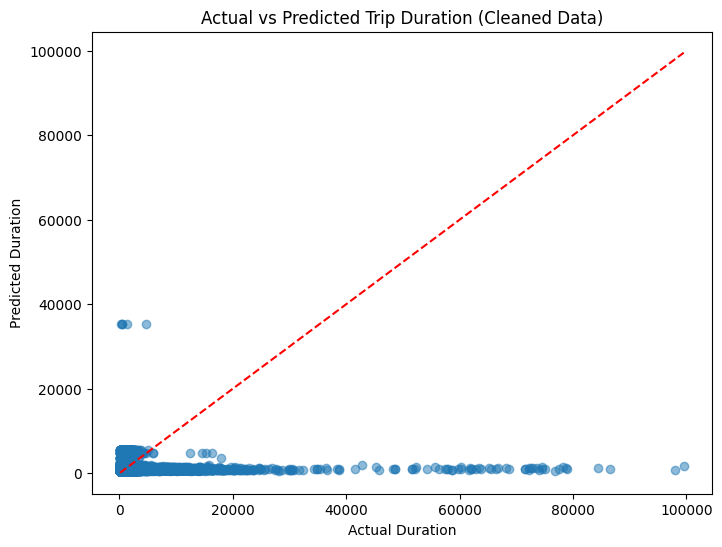

In [101]:
# Re-plot scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_cleaned_actual, y_cleaned_predicted, alpha=0.5)
plt.plot(
    [y_cleaned_actual.min(), y_cleaned_actual.max()],
    [y_cleaned_actual.min(), y_cleaned_actual.max()], 'r--'
)
plt.xlabel("Actual Duration")
plt.ylabel("Predicted Duration")
plt.title("Actual vs Predicted Trip Duration (Cleaned Data)")
plt.show()

In [102]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print("MAE (Cleaned):", mean_absolute_error(y_cleaned_actual, y_cleaned_predicted))
print("MSE (Cleaned):", mean_squared_error(y_cleaned_actual, y_cleaned_predicted))
print("R² (Cleaned):", r2_score(y_cleaned_actual, y_cleaned_predicted))

MAE (Cleaned): 520.8756613758741
MSE (Cleaned): 916240.7896802408
R² (Cleaned): -0.0003085821327497573


## Phase 6: Model Deployment

### Step 1: Save the Trained Model

In [103]:
import joblib

In [104]:
# Save the best Random Forest model
joblib.dump(best_rf_model, "BikeML/models/bike_duration_predictor.pkl")
print("Model saved successfully!")

Model saved successfully!
